In [2]:
# download stock_price_data, option_price_data, gamma_data, delta_data

from functions import *
from simulation import *
from policy_simulation import *
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random



In [3]:
stock_price_path = np.load('stock_price_data.npy')
stock_price_path = stock_price_path.tolist()

# randomly choose 10 stock price paths
new_stock_price_path = []
for i in range(5):
    new_stock_price_path += stock_price_path[i]

new_stock_price_path
new_stock_price_path = [new_stock_price_path]
new_stock_price_path

[[1.0,
  0.9038197809919004,
  0.9204914915440081,
  0.9495493010075058,
  0.8936092037184845,
  0.8797401261553373,
  0.9725341721288805,
  1.0199249828992745,
  1.0665280111824533,
  0.9490422625615971,
  1.0,
  1.004125273579559,
  0.920444530701085,
  0.947292024310423,
  1.032523987631037,
  1.07660872239709,
  1.0944456275361265,
  1.0819229925497944,
  0.9658489495237015,
  1.0610674219996579,
  1.0,
  1.0443293690108497,
  1.1292199388881032,
  1.0662819558219092,
  1.1172958508973945,
  1.059286039638192,
  1.1049268093683122,
  1.1949269321813474,
  1.2354405771096355,
  1.4241243590414814,
  1.0,
  1.1297353095273548,
  1.0807927191646372,
  1.1172072393495533,
  1.1152212699234494,
  1.0936833279262486,
  1.0815384814541373,
  0.9646337868142553,
  0.9944124705000692,
  1.0246170192310882,
  1.0,
  1.0012415085356257,
  0.9988270286971047,
  1.0545271041608535,
  0.9785452809427965,
  1.0321510039883208,
  1.0036004311177888,
  1.006073462679763,
  1.0829793970419805,
  1.0

In [4]:
def new_reward_distribution(policy, paras, num_path, new_stock_price_path):
    # num_path is the number of simulated trading of the current policy we are conducting

    terminal_wealths = [] 
    inventory_paths = []
    for i in range(num_path):
        stock_path = random.choice(new_stock_price_path)
        option_price, option_delta, option_gamma, option_theta = option_simulation_final(paras.V, stock_path, paras.T, paras.dt, paras.K, paras.time, paras.r, paras.sigma)
        inv, buy, sell, reward = entire_trading_final(policy, option_price, stock_path, paras.dt, paras.A, paras.kappa, paras.phi, option_gamma, option_theta, paras.sigma, paras.gamma)
        # after getting the inventory, we can calculate the reward
        inventory_paths.append(inv)
        terminal_wealths.append(reward)

    return inventory_paths, terminal_wealths

In [5]:
# some hyperparameters that's will be fixed for the simulation 

################################################################################################
# we will consider n different call options
n = 2

# bid_range is n * n * ... * n = n^10
# for each call option, we will consider 10 different bid spreads

bid_values = np.linspace(0.1, 0.4, 4)
ask_values = np.linspace(0.1, 0.4, 4)

# we will consider n different call options, each option has len(bid_values) different bid spreads
# so bid_range will be high dimensional tensor of shape len(bid_values) * len(bid_values) * ... * len(bid_values) = len(bid_values)^n
bid_ranges = np.array(np.meshgrid(*[bid_values for _ in range(n)])).T.reshape(-1, n)
ask_ranges = np.array(np.meshgrid(*[ask_values for _ in range(n)])).T.reshape(-1, n)

################################################################################################


# the entire trading period is T
# each trading time step is dt
T = 1
dt = 0.02
r = 0 
S0 = 1.00

# generate the identity matrix of size n
V = np.eye(n)

# generate the strike prices for the n call options
K = np.linspace(0.8, 1.2, n)
time = np.linspace(10, 20, n)
A = 10
kappa = 1

# final value penalty 
phi = 1
# policy penalty: gamma
gamma = 0.1

# epoch is the number of trading we simulate over one stock_path
epoch = 1

In [6]:
# I found that if there are so many parameters
# it is better to use a class to store all the parameters
class TradingParameters:
    def __init__(self, sigma, S0, T, dt, r, V, K, time, m, A, kappa, bid_ranges, ask_ranges, phi, gamma, epoch):
        self.sigma = sigma
        self.S0 = S0
        self.T = T
        self.dt = dt
        self.r = r
        self.V = V
        self.K = K
        self.time = time
        self.A = A
        self.kappa = kappa
        self.bid_ranges = bid_ranges
        self.ask_ranges = ask_ranges
        self.phi = phi
        self.gamma = gamma
        self.epoch = epoch

paras = TradingParameters(0.2, S0, T, dt, r, V, K, time, n, A, kappa, bid_ranges, ask_ranges, phi, gamma, epoch)

In [7]:
# load the first value net
first_value_net = Net(2)
first_value_net.load_state_dict(torch.load('random_value_oarams'))
# create the TradingPolicy object
first_policy = TradingPolicy(first_value_net, paras.gamma, paras.A, paras.kappa, paras.bid_ranges, paras.ask_ranges)

# load the second value net
second_value_net = Net(2)
second_value_net.load_state_dict(torch.load('first_value_net_params'))
# create the TradingPolicy object
second_policy = TradingPolicy(second_value_net, paras.gamma, paras.A, paras.kappa, paras.bid_ranges, paras.ask_ranges)

# load the third value net
third_value_net = Net(2)
third_value_net.load_state_dict(torch.load('second_value_net_parameters'))
# create the TradingPolicy object
third_policy = TradingPolicy(third_value_net, paras.gamma, paras.A, paras.kappa, paras.bid_ranges, paras.ask_ranges)

# load the fourth value net
fourth_value_net = Net(2)
fourth_value_net.load_state_dict(torch.load('third_value_net_parameters'))
# create the TradingPolicy object
fourth_policy = TradingPolicy(fourth_value_net, paras.gamma, paras.A, paras.kappa, paras.bid_ranges, paras.ask_ranges)

# load the fifth value net
fifth_value_net = Net(2)
fifth_value_net.load_state_dict(torch.load('forth_value_net_parameters'))
# create the TradingPolicy object
fifth_policy = TradingPolicy(fifth_value_net, paras.gamma, paras.A, paras.kappa, paras.bid_ranges, paras.ask_ranges)


In [ ]:
# simulate the trading, and get the reward
first_inv_path, first_reward_dist = new_reward_distribution(first_policy, paras, 10, new_stock_price_path)

In [ ]:
second_inv_path, second_reward_dist = new_reward_distribution(second_policy, paras, 10, new_stock_price_path)

In [ ]:
third_inv_path, third_reward_dist = new_reward_distribution(third_policy, paras, 10, new_stock_price_path)

In [ ]:
fourth_inv_path, fourth_reward_dist = new_reward_distribution(fourth_policy, paras, 10, new_stock_price_path)

In [ ]:
fifth_inv_path, fifth_reward_dist = new_reward_distribution(fifth_policy, paras, 10, new_stock_price_path)  

In [ ]:

inv_path = [first_inv_path, second_inv_path, third_inv_path, fourth_inv_path, fifth_inv_path]
#reward_dist = [first_reward_dist, second_reward_dist, third_reward_dist, fourth_reward_dist, fifth_reward_dist]

# make them into numpy array
inv_path = np.array(inv_path)
#reward_dist = np.array(reward_dist)

# save the inventory path and reward distribution
#np.save('inventory_path', inv_path)
#np.save('reward_distribution', reward_dist)
inv_path.shape


(5, 10, 50, 2)

In [ ]:
# save 
long_inv_path = inv_path
np.save('long_inventory_path', long_inv_path)

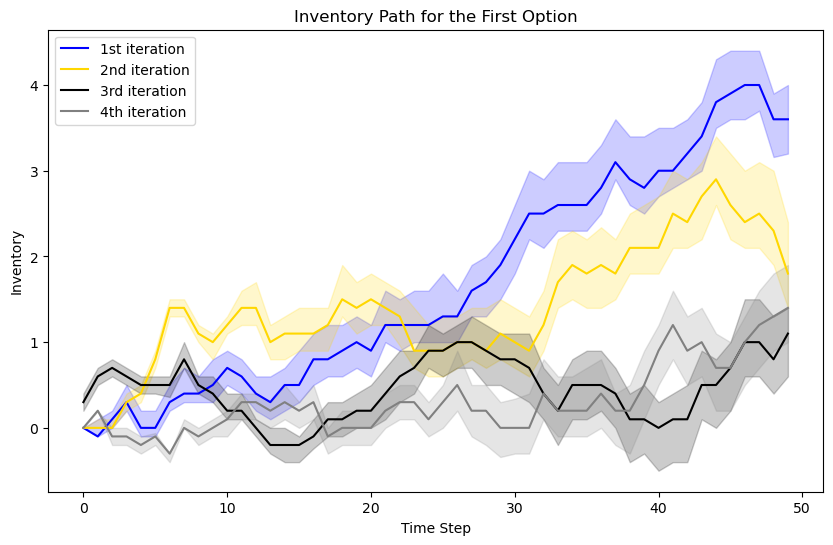

In [9]:
import pandas as pd
import seaborn as sns

inv_path = np.load('long_inventory_path.npy')

first_option_1_iter = inv_path[1, :, :, 0]
first_option_2_iter = inv_path[2, :, :, 0]
first_option_3_iter = inv_path[3, :, :, 0]
first_option_4_iter = inv_path[4, :, :, 0]

first_option_1_iter_df = pd.DataFrame(first_option_1_iter)
first_option_2_iter_df = pd.DataFrame(first_option_2_iter)
first_option_3_iter_df = pd.DataFrame(first_option_3_iter)
first_option_4_iter_df = pd.DataFrame(first_option_4_iter)

# make the index and new column names for first_option df

# make the index the new column names
# extract all points' value to be another column

melt_1_option_1_iter = first_option_1_iter_df.melt(var_name='time_step', value_name='inventory')
melt_1_option_2_iter = first_option_2_iter_df.melt(var_name='time_step', value_name='inventory')
melt_1_option_3_iter = first_option_3_iter_df.melt(var_name='time_step', value_name='inventory')
melt_1_option_4_iter = first_option_4_iter_df.melt(var_name='time_step', value_name='inventory')


fig = plt.figure(figsize=(10, 6))

# Plot the data
sns.lineplot(x='time_step', y='inventory', data=melt_1_option_1_iter, label='1st iteration', color = 'blue', errorbar=('ci', 20))
sns.lineplot(x='time_step', y='inventory', data=melt_1_option_2_iter, label='2nd iteration', color = 'gold', errorbar=('ci', 20))
sns.lineplot(x='time_step', y='inventory', data=melt_1_option_3_iter, label='3rd iteration', color = 'black', errorbar=('ci', 20))
sns.lineplot(x='time_step', y='inventory', data=melt_1_option_4_iter, label='4th iteration', color = 'grey', errorbar=('ci', 20))

# Setting labels and title
plt.xlabel('Time Step')
plt.ylabel('Inventory')
plt.title('Inventory Path for the First Option')
plt.savefig('inventory_path_first_option.png')
plt.show()


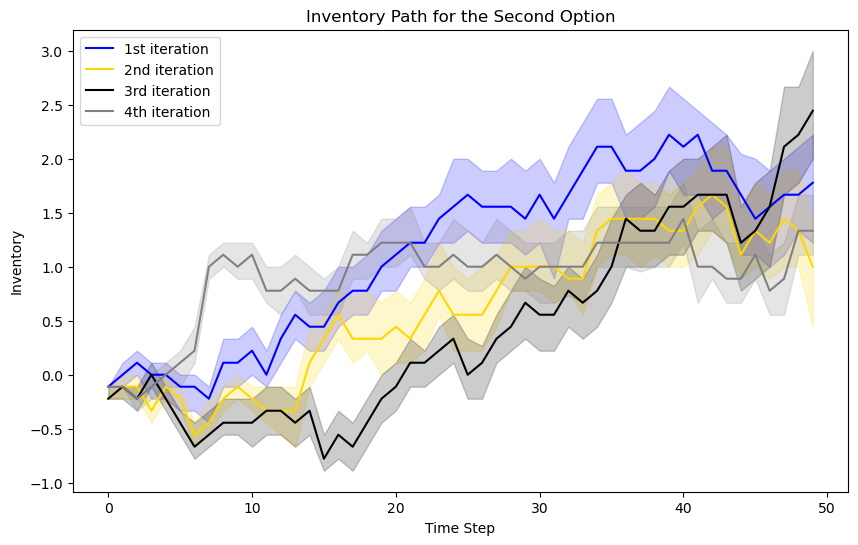

In [10]:
second_option_1_iter = inv_path[1, :9, :, 1]
second_option_2_iter = inv_path[2, :9, :, 1]
second_option_3_iter = inv_path[3, :9, :, 1]
second_option_4_iter = inv_path[4, :9, :, 1]

second_option_1_iter_df = pd.DataFrame(second_option_1_iter)
second_option_2_iter_df = pd.DataFrame(second_option_2_iter)
second_option_3_iter_df = pd.DataFrame(second_option_3_iter)
second_option_4_iter_df = pd.DataFrame(second_option_4_iter)

# make the index the new column names
# extract all points' value to be another column

melt_2_option_1_iter = second_option_1_iter_df.melt(var_name='time_step', value_name='inventory')
melt_2_option_2_iter = second_option_2_iter_df.melt(var_name='time_step', value_name='inventory')
melt_2_option_3_iter = second_option_3_iter_df.melt(var_name='time_step', value_name='inventory')
melt_2_option_4_iter = second_option_4_iter_df.melt(var_name='time_step', value_name='inventory')


fig = plt.figure(figsize=(10, 6))

# Plot the data
sns.lineplot(x='time_step', y='inventory', data=melt_2_option_1_iter, label='1st iteration', color = 'blue', errorbar= ('ci', 20))
sns.lineplot(x='time_step', y='inventory', data=melt_2_option_2_iter, label='2nd iteration', color = 'gold', errorbar= ('ci', 20))
sns.lineplot(x='time_step', y='inventory', data=melt_2_option_3_iter, label='3rd iteration', color = 'black', errorbar= ('ci', 20))
sns.lineplot(x='time_step', y='inventory', data=melt_2_option_4_iter, label='4th iteration', color = 'grey', errorbar= ('ci', 20))

# Setting labels and title
plt.xlabel('Time Step')
plt.ylabel('Inventory')
plt.title('Inventory Path for the Second Option')
plt.savefig('inventory_path_second_option.png')
plt.show()
